# Comparación consolidada de corridas

- Un solo barplot con métricas (cobertura %, violaciones, RTB) renombradas.
- Renombrado de labels: Alg. Genético, Alg. Greedy, MARL con obstáculos, MARL sin obstáculos.
- Curvas de evolución (cobertura y POIs servidos) en gráficas únicas por métrica, con líneas de colores por corrida.
- Tabla consolidada de evolución por tick (sin violaciones).

In [2]:
from pathlib import Path
import ast
import re
import pandas as pd
import matplotlib.pyplot as plt

LABEL_MAP = {
    "genetica2": "Alg. Genético",
    "genetica": "Alg. Genético",
    "greedy2": "Alg. Greedy",
    "greedy": "Alg. Greedy",
    "poli with obstacles": "MARL con obstáculos",
    "poli without obstacles": "MARL sin obstáculos",
    "politic with obstacles": "MARL con obstáculos",
    "politic without obstacles": "MARL sin obstáculos",
}

def parse_final_line(line: str):
    clean = line.replace("[final]", "").strip()
    tokens = {}
    for m in re.finditer(r"(\w+)=({[^}]*}|[^\s]+)", clean):
        key, val = m.group(1), m.group(2)
        tokens[key] = val
    def get_str(k, default=""):
        return tokens.get(k, default)
    try:
        policy = get_str("policy", "unknown")
        serv_tok = get_str("serv", "0/1")
        served_str, total_str = serv_tok.split("/", 1) if "/" in serv_tok else (serv_tok, "1")
        served, total = int(served_str), int(total_str)
        coverage = float(get_str("cov", "0").replace("%", "")) / 100.0
        violations = int(get_str("viol", "0"))
        rtb = int(get_str("rtb", "0"))
        return {
            "policy": policy,
            "served": served,
            "total": total,
            "coverage": coverage,
            "violations": violations,
            "rtb": rtb,
        }
    except Exception:
        return None

def load_results(paths):
    rows = []
    for p in paths:
        text = Path(p).read_text(encoding="utf-8", errors="ignore").splitlines()
        final_line = None
        for line in reversed(text):
            if "policy=" in line:
                final_line = line
                break
        if not final_line:
            continue
        parsed = parse_final_line(final_line)
        if not parsed:
            continue
        label = Path(p).parent.name
        parsed["label_raw"] = label
        parsed["label"] = LABEL_MAP.get(label, label)
        parsed["path"] = str(p)
        parsed["coverage_pct"] = parsed["coverage"] * 100
        rows.append(parsed)
    return pd.DataFrame(rows)

# Parseo de líneas [paso ...] para curvas de evolución
STEP_RE = re.compile(r"\[paso\s+(?P<step>\d+)\]\s+tick=(?P<tick>\d+)\s+serv=(?P<served>\d+)/(?P<total>\d+)\s+cov=(?P<cov>[\d\.]+)%\s+.*?viol=(?P<viol>\d+)")

def parse_steps(path: Path) -> pd.DataFrame:
    rows = []
    for line in path.read_text(encoding="utf-8", errors="ignore").splitlines():
        m = STEP_RE.search(line)
        if not m:
            continue
        d = m.groupdict()
        rows.append({
            "tick": int(d["tick"]),
            "served": int(d["served"]),
            "total": int(d["total"]),
            "coverage": float(d["cov"]),
            # violations se omite de la comparación de curvas por solicitud
        })
    return pd.DataFrame(rows)

def consolidate_steps(df_final: pd.DataFrame):
    dfs = []
    for _, row in df_final.iterrows():
        steps = parse_steps(Path(row['path']))
        steps["label"] = row["label"]
        dfs.append(steps)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Config rutas
FILES = []  # Rellena si quieres rutas específicas
if FILES:
    paths = [Path(p) for p in FILES]
else:
    preferred = [
        Path("results/routes/poli with obstacles/results.txt"),
        Path("results/routes/poli without obstacles/results.txt"),
        Path("results/routes/greedy2/results.txt"),
        Path("results/routes/genetica2/results.txt"),
    ]
    paths = [p for p in preferred if p.exists()]
    if not paths:
        paths = list(Path("results/routes").rglob("results.txt"))

df_final = load_results(paths)
df_final

,policy,served,total,coverage,violations,rtb,label_raw,label,path,coverage_pct
0,marl,15,50,0.30,4,20,poli with obstacles,MARL con obstáculos,results\routes\poli with obstacles\results.txt,30.0
1,marl,19,50,0.38,5,20,poli without obstacles,MARL sin obstáculos,results\routes\poli without obstacles\results.txt,38.0
2,greedy,1,50,0.02,0,4,greedy2,Alg. Greedy,results\routes\greedy2\results.txt,2.0
3,genetic,44,50,0.88,4,0,genetica2,Alg. Genético,results\routes\genetica2\results.txt,88.0


C:\Users\chori\AppData\Local\Temp\ipykernel_29156\2642799330.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order["label"], rotation=30, ha="right")
C:\Users\chori\AppData\Local\Temp\ipykernel_29156\2642799330.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order["label"], rotation=30, ha="right")
C:\Users\chori\AppData\Local\Temp\ipykernel_29156\2642799330.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order["label"], rotation=30, ha="right")


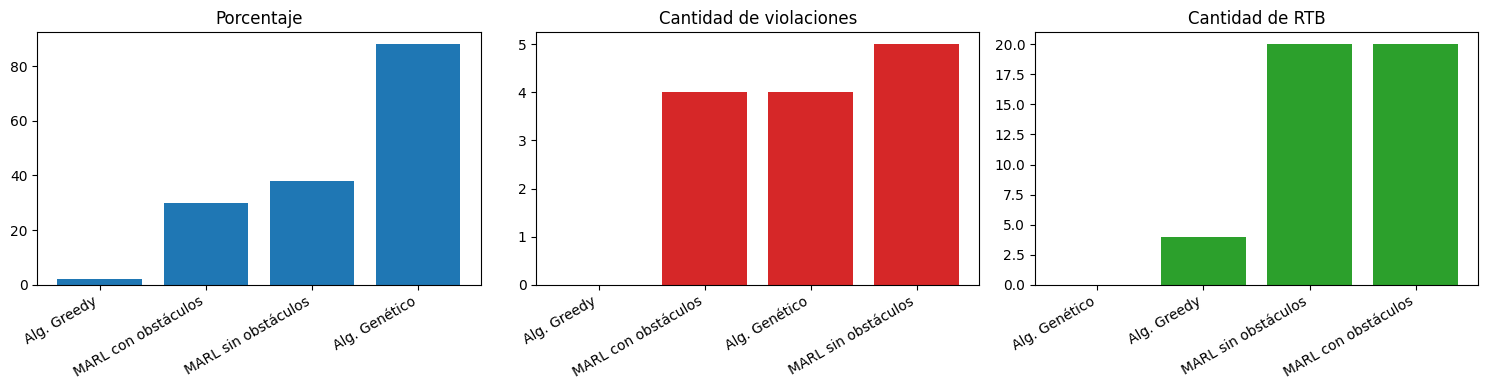

In [7]:
# Barplot consolidado: Cobertura (%), Violaciones, RTB
if not df_final.empty:
    metrics = [
        ("coverage_pct", "Porcentaje", "tab:blue"),
        ("violations", "Cantidad de violaciones", "tab:red"),
        ("rtb", "Cantidad de RTB", "tab:green"),
    ]
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 4))
    for ax, (col, ylabel, color) in zip(axes, metrics):
        order = df_final.sort_values(col)
        ax.bar(order["label"], order[col], color=color)
        ax.set_title(ylabel)
        ax.set_xticklabels(order["label"], rotation=30, ha="right")
    fig.tight_layout()
    plt.show()
else:
    print("[error] no se encontraron resultados válidos")


In [4]:
# Consolidar evolución por tick (sin violaciones) y graficar coberturas/servidos en una sola curva por métrica
df_steps_all = consolidate_steps(df_final)
df_steps_all

,tick,served,total,coverage,label
0,1,0,50,0.0,MARL con obstáculos
1,2,0,50,0.0,MARL con obstáculos
2,3,0,50,0.0,MARL con obstáculos
3,4,0,50,0.0,MARL con obstáculos
4,5,0,50,0.0,MARL con obstáculos
...,...,...,...,...,...
11995,2996,44,50,88.0,Alg. Genético
11996,2997,44,50,88.0,Alg. Genético
11997,2998,44,50,88.0,Alg. Genético
11998,2999,44,50,88.0,Alg. Genético


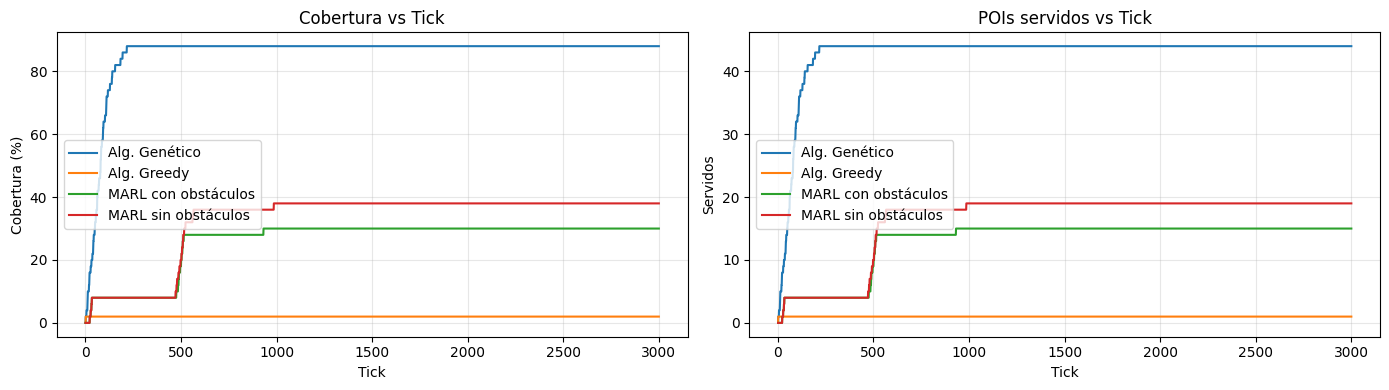

In [6]:
if not df_steps_all.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Cobertura vs tick
    ax = axes[0]
    for label, grp in df_steps_all.groupby("label"):
        ax.plot(grp["tick"], grp["coverage"], label=label)
    ax.set_title("Cobertura vs Tick")
    ax.set_xlabel("Tick")
    ax.set_ylabel("Cobertura (%)")
    ax.legend()
    ax.grid(alpha=0.3)

    # POIs servidos vs tick
    ax = axes[1]
    for label, grp in df_steps_all.groupby("label"):
        ax.plot(grp["tick"], grp["served"], label=label)
    ax.set_title("POIs servidos vs Tick")
    ax.set_xlabel("Tick")
    ax.set_ylabel("Servidos")
    ax.legend()
    ax.grid(alpha=0.3)

    fig.tight_layout()
    plt.show()
else:
    print("[warn] no hay datos de evolución por tick (logs sin [paso ...])")
